Setting up VOC dataset structure...
Dataset setup complete.

ARCH: resnet18
Loading CropMix weights from disk...
  Training resnet18 [CropMix]...
    -> CropMix Finished in 241.9s. Final Loss: 0.2143
Loading NoCropMix weights from disk...
  Training resnet18 [NoCropMix]...
    -> NoCropMix Finished in 213.7s. Final Loss: 0.2325
Loading FineTuning weights from disk...
  Training resnet18 [FineTuning]...
    -> FineTuning Finished in 214.4s. Final Loss: 0.2182
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 229MB/s]

  Training resnet18 [ImageNet]...


    -> ImageNet Finished in 216.4s. Final Loss: 0.1260
  Training resnet18 [Random]...
    -> Random Finished in 213.9s. Final Loss: 0.2327


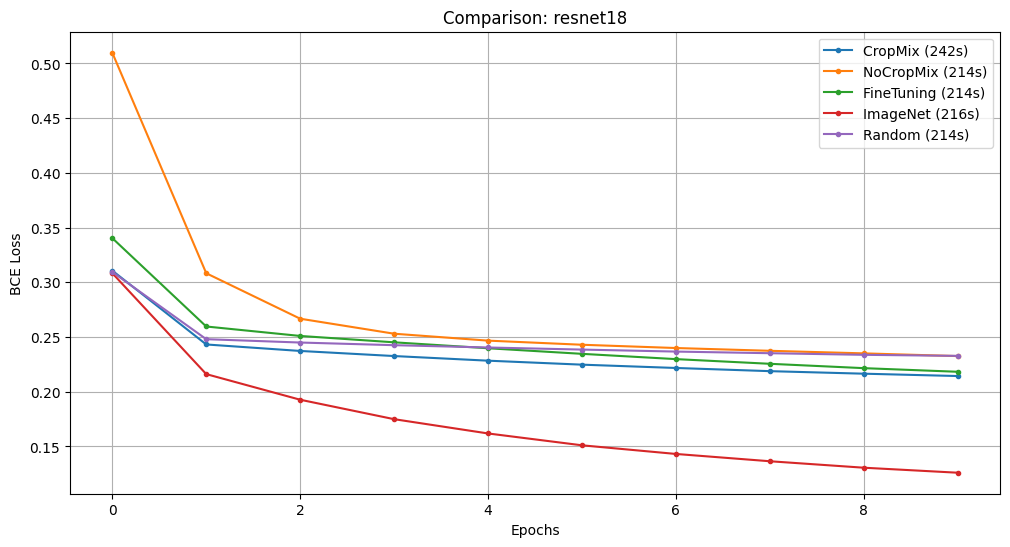


ARCH: resnet50
Loading CropMix weights from disk...
  Training resnet50 [CropMix]...
    -> CropMix Finished in 314.2s. Final Loss: 0.2086
Loading NoCropMix weights from disk...
  Training resnet50 [NoCropMix]...
    -> NoCropMix Finished in 314.1s. Final Loss: 0.2311
Loading FineTuning weights from disk...
  Training resnet50 [FineTuning]...
    -> FineTuning Finished in 314.1s. Final Loss: 0.2537
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 183MB/s]


  Training resnet50 [ImageNet]...
    -> ImageNet Finished in 314.2s. Final Loss: 0.1504
  Training resnet50 [Random]...
    -> Random Finished in 314.1s. Final Loss: 0.2448


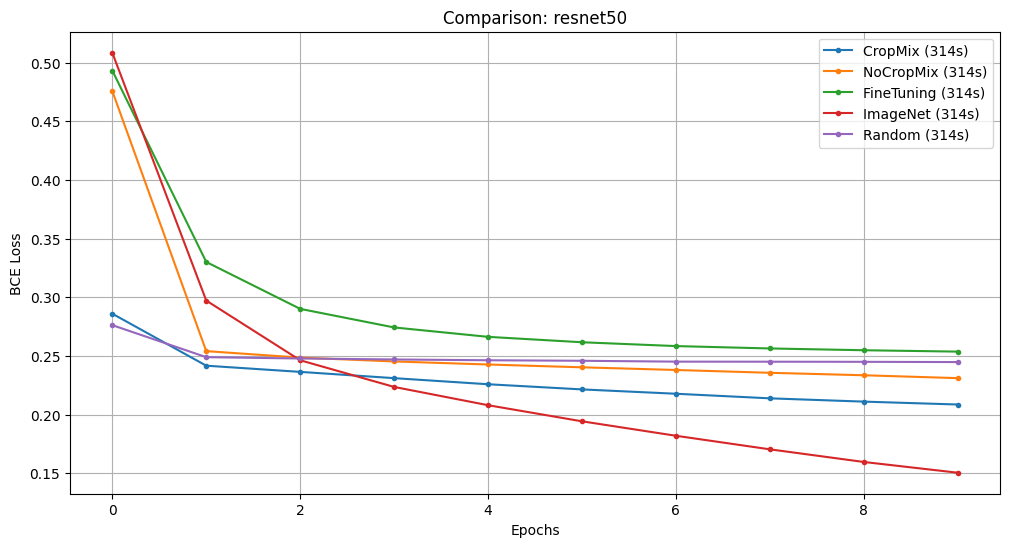


ARCH: efficientnet_b0
>> Switching to 300x300 for efficientnet_b0
Loading CropMix weights from disk...
  Training efficientnet_b0 [CropMix]...
    -> CropMix Finished in 234.4s. Final Loss: 0.2397
Loading NoCropMix weights from disk...
  Training efficientnet_b0 [NoCropMix]...
    -> NoCropMix Finished in 231.0s. Final Loss: 0.3092
Loading FineTuning weights from disk...
  Training efficientnet_b0 [FineTuning]...
    -> FineTuning Finished in 235.1s. Final Loss: 0.2513
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 206MB/s]

  Training efficientnet_b0 [ImageNet]...


    -> ImageNet Finished in 235.9s. Final Loss: 0.2122
  Training efficientnet_b0 [Random]...
    -> Random Finished in 233.5s. Final Loss: 0.2401


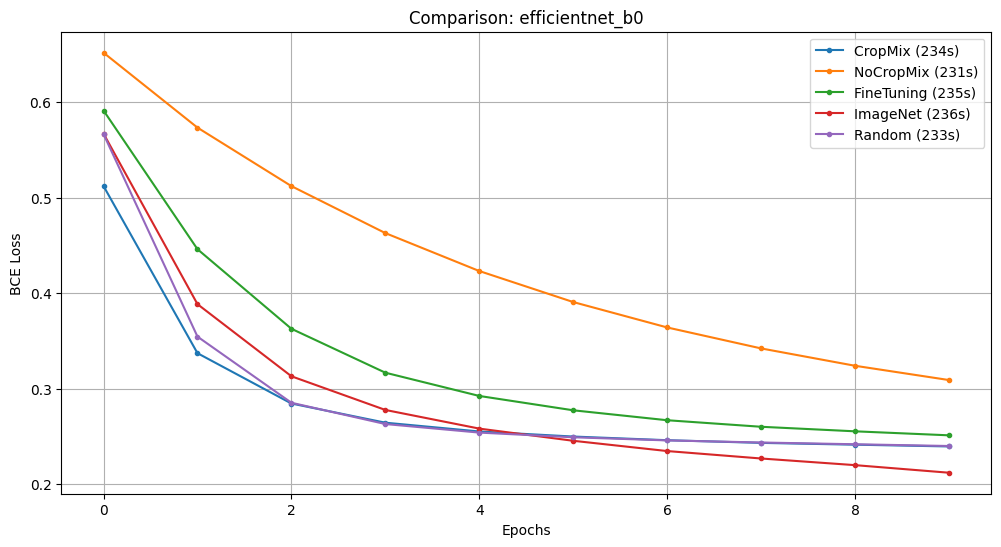


ARCH: efficientnet_b3
>> Switching to 224x224 for efficientnet_b3
Loading CropMix weights from disk...
  Training efficientnet_b3 [CropMix]...
    -> CropMix Finished in 401.8s. Final Loss: 0.3426
Loading NoCropMix weights from disk...
  Training efficientnet_b3 [NoCropMix]...
    -> NoCropMix Finished in 401.7s. Final Loss: 0.3012
Loading FineTuning weights from disk...
  Training efficientnet_b3 [FineTuning]...
    -> FineTuning Finished in 401.0s. Final Loss: 0.2522
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:00<00:00, 205MB/s]


  Training efficientnet_b3 [ImageNet]...
    -> ImageNet Finished in 400.9s. Final Loss: 0.2272
  Training efficientnet_b3 [Random]...
    -> Random Finished in 401.1s. Final Loss: 0.2527


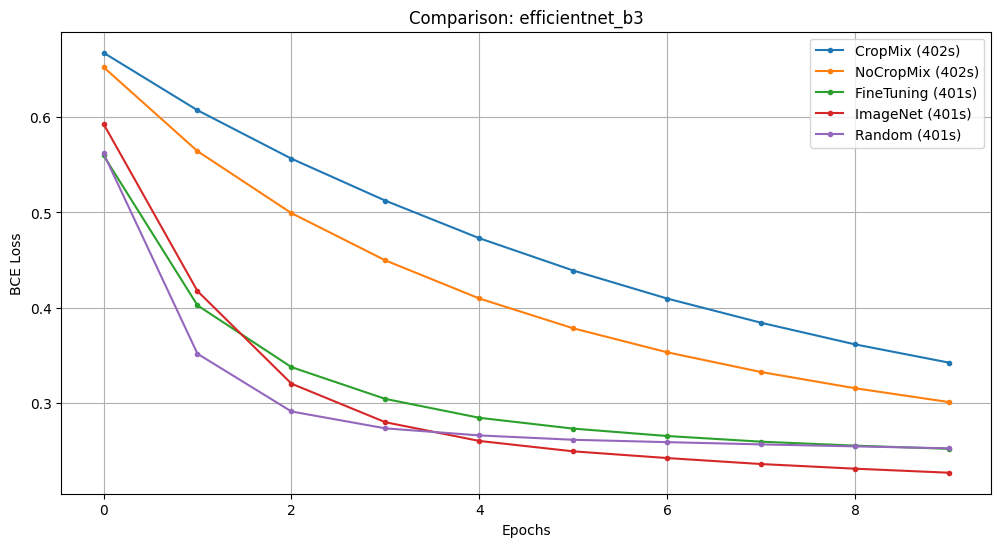


ARCH: inception_v3
>> Switching to 299x299 for inception_v3


/usr/local/lib/python3.12/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Loading CropMix weights from disk...
  Training inception_v3 [CropMix]...


RuntimeError: Calculated padded input size per channel: (3 x 3). Kernel size: (5 x 5). Kernel size can't be greater than actual input size

<Figure size 1200x600 with 0 Axes>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import shutil

# --- 1. CONFIGURATION ---
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 10 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define path roots for clarity
# Root 1: From Screenshot 1
PATH_TASK = '/kaggle/input/image-orientation-pretext-task-models/pytorch/default/1'

# MASTER CONFIGURATION: Map every model variant to its exact file path
# We map: Architecture -> Variant -> Path
model_configs = {
    'resnet18': {
        'CropMix':    f'{PATH_TASK}/fullTraining_ResNet18.pth',
        'NoCropMix':  f'{PATH_TASK}/fullTraining_ResNet18_nocropmix.pth',
        'FineTuning': f'{PATH_TASK}/fineTuning_ResNet18.pth',
    },
    'resnet50': {
        'CropMix':    f'{PATH_TASK}/fullTraining_ResNet50.pth',
        'NoCropMix':  f'{PATH_TASK}/fullTraining_ResNet50_nocropmix.pth',
        'FineTuning': f'{PATH_TASK}/fineTuning_ResNet50.pth',
    },
    'efficientnet_b0': {
        'CropMix':    f'{PATH_TASK}/fullTraining_EfficientNetB0.pth',
        'NoCropMix':  f'{PATH_TASK}/fullTraining_EfficientNetB0_nocropmix.pth',
        'FineTuning': f'{PATH_TASK}/fineTuning_EfficientNetB0.pth',
    },
    'efficientnet_b3': {
        'CropMix':    f'{PATH_TASK}/fullTraining_EfficientNetB3.pth',
        'NoCropMix':  f'{PATH_TASK}/fullTraining_EfficientNetB3_nocropmix.pth',
        'FineTuning': f'{PATH_TASK}/fineTuning_EfficientNetB3.pth',
    },
    'inception_v3': {
        'CropMix':    f'{PATH_TASK}/fullTraining_InceptionV3.pth',
        'NoCropMix':  f'{PATH_TASK}/fullTraining_InceptionV3_nocropmix.pth',
        'FineTuning': f'{PATH_TASK}/fineTuning_InceptionV3.pth',
    },
    'simple_CNN':{
        'CropMix':    f'{PATH_TASK}/SimpleRotationCNN.pth',
        'NoCropMix':  f'{PATH_TASK}/SimpleRotationCNN224_nocropmix.pth',
    }
}

VOC_CLASSES = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 
    'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

# --- 2. AUTOMATIC DATASET SETUP ---
def setup_voc_structure():
    input_root = '/kaggle/input/pascal-voc-2012-dataset'
    working_voc_dir = '/kaggle/working/VOCdevkit/VOC2012'
    
    if os.path.exists(working_voc_dir) and os.path.exists(os.path.join(working_voc_dir, 'JPEGImages')):
        print("Dataset structure already exists.")
        return

    print("Setting up VOC dataset structure...")
    source_voc_dir = None
    for root, dirs, files in os.walk(input_root):
        if 'JPEGImages' in dirs:
            source_voc_dir = root
            break
            
    if not source_voc_dir:
        raise FileNotFoundError("Could not find VOC data in input!")

    os.makedirs(working_voc_dir, exist_ok=True)
    
    folders = ['Annotations', 'ImageSets', 'JPEGImages', 'SegmentationClass', 'SegmentationObject']
    for folder in folders:
        src = os.path.join(source_voc_dir, folder)
        dst = os.path.join(working_voc_dir, folder)
        if os.path.exists(src) and not os.path.exists(dst):
            os.symlink(src, dst)
            
    print("Dataset setup complete.")

setup_voc_structure()

# --- 3. DATASET HANDLING & TRANSFORMS ---
class PascalVOC_Classification(datasets.VOCDetection):
    def __init__(self, root, year, image_set, download=False, transform=None):
        super().__init__(root, year, image_set, download=download, transform=transform)
        self.class_to_idx = {name: i for i, name in enumerate(VOC_CLASSES)}

    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        label_vector = torch.zeros(20, dtype=torch.float32)
        objects = target['annotation']['object']
        if not isinstance(objects, list):
            objects = [objects]
        for obj in objects:
            class_name = obj['name']
            if class_name in self.class_to_idx:
                idx = self.class_to_idx[class_name]
                label_vector[idx] = 1.0
        return img, label_vector

# Define both transforms
transform_standard = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_efficientNetB0 = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_inception = transforms.Compose([
    transforms.Resize((299, 299)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize Dataset (Default to standard)
train_dataset = PascalVOC_Classification(
    root='/kaggle/working', 
    year='2012',
    image_set='train',
    download=False,
    transform=transform_standard
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)


# --- 4. MODEL BUILDER ---
def build_model(architecture, variant, custom_path=None):
    """
    variant: 'ImageNet', 'Random', 'CropMix', 'NoCropMix', 'FineTuning'
    """
    # A. Initialize Base Weights
    if variant == 'ImageNet':
        model = getattr(models, architecture)(weights='DEFAULT')
    elif variant == 'Random':
        model = getattr(models, architecture)(weights=None)
    else:
        # For our custom models, we usually start with None or Default. 
        # Using None ensures we are testing OUR weights, not ImageNet residue.
        model = getattr(models, architecture)(weights=None) 
    
    # B. Load Custom Weights (if applicable)
    if variant in ['CropMix', 'NoCropMix', 'FineTuning'] and custom_path:
        if not os.path.exists(custom_path):
            print(f"!! ERROR: File not found {custom_path}. Using Random weights for {variant} !!")
        else:
            print(f"Loading {variant} weights from disk...")
            checkpoint = torch.load(custom_path, map_location='cpu')
            state_dict = checkpoint.state_dict() if isinstance(checkpoint, nn.Module) else \
                         checkpoint.get('state_dict', checkpoint)
            
            if list(state_dict.keys())[0].startswith('module.'):
                state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
            
            # Filter out head (fc/classifier)
            filtered_dict = {k: v for k, v in state_dict.items() 
                             if not ('fc' in k or 'classifier' in k or 'AuxLogits' in k)}
            try:
                model.load_state_dict(filtered_dict, strict=False)
            except Exception as e:
                print(f"Error loading {variant}: {e}")

    # C. Replace Head for VOC (20 Classes)
    if 'resnet' in architecture or 'inception' in architecture:
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 20)
    elif 'efficientnet' in architecture:
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, 20)
    
    return model.to(DEVICE)


# --- 5. TRAINING FUNCTION ---
def train_model(model, arch_name, variant_name):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
    loss_history = []
    
    model.train()
    print(f"  Training {arch_name} [{variant_name}]...")
    
    for epoch in range(EPOCHS):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            
            if arch_name == 'inception_v3':
                outputs, aux = model(inputs)
                loss = criterion(outputs, labels)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)
        # print(f"    Ep {epoch+1}: {epoch_loss:.4f}") # Uncomment for verbose logs

    return loss_history


# --- 6. EXECUTION LOOP ---
# Defines the 5 variants we want to compare
VARIANTS_TO_TEST = ['CropMix', 'NoCropMix', 'FineTuning', 'ImageNet', 'Random']

for arch, paths in model_configs.items():
    print(f"\n{'='*60}")
    print(f"ARCH: {arch}")
    print(f"{'='*60}")
    
    # 1. Handle Inception Resize Logic
    if arch == 'inception_v3':
        print(f">> Switching to 299x299 for {arch}")
        train_dataset.transform = transform_inception
    elif arch == 'efficientnet_b0':
        print(f">> Switching to 300x300 for {arch}")
        train_dataset.transform = transform_efficientNetB0
    elif train_dataset.transform != transform_standard:
        print(f">> Switching to 224x224 for {arch}")
        train_dataset.transform = transform_standard

    # 2. Train all variants for this architecture
    plt.figure(figsize=(12, 6))
    
    for variant in VARIANTS_TO_TEST:
        custom_path = paths.get(variant, None) # Gets path if it exists (for custom ones)
        
        # Build
        model = build_model(arch, variant, custom_path)
        
        # Train & Record
        start_t = time.time()
        loss_hist = train_model(model, arch, variant)
        duration = time.time() - start_t
        
        # Plot immediately
        plt.plot(loss_hist, label=f"{variant} ({duration:.0f}s)", marker='.')
        print(f"    -> {variant} Finished in {duration:.1f}s. Final Loss: {loss_hist[-1]:.4f}")

    # 3. Finalize Plot for this Architecture
    plt.title(f'Comparison: {arch}')
    plt.xlabel('Epochs')
    plt.ylabel('BCE Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

print("\nAll comparisons complete.")